# Portfolio Optimization
created by krohak 2018-01-16

In [83]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo

def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))


def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Adj Close'], na_values=['nan'])
        df_temp.rename(columns={'Adj Close': symbol}, inplace=True)
        df = df.join(df_temp)
        if symbol == 'SPY':  # drop dates SPY did not trade
            df = df.dropna(subset=["SPY"])
    return df

def compute_daily_returns(df,portfolio=False):
    """Compute and return the daily return values."""
    daily_returns = (df / df.shift(1)) - 1
    
    if portfolio:
        daily_returns.iloc[0] = 0
        return daily_returns
    
    daily_returns.iloc[0, :] = 0
    return daily_returns

def plot_data(df, title="Stock prices", xlabel="Date", ylabel="Price"):
    """Plot stock prices with a custom title and meaningful axis labels."""
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()
    
def normalize_data(df,daily_return=False):
    if daily_return:
        return df / df.iloc[1, :]
    return df / df.iloc[0, :]

def cumulative_daily_return(df):
    # Cumulative Return (last/first-1)
    daily_return = compute_daily_returns(df)
    cumulative_daily_return = (daily_return.iloc[-1,:]/daily_return.iloc[1,:])-1
    return cumulative_daily_return

def average_daily_return(df):
    daily_return = compute_daily_returns(df)
    return daily_return.mean(axis=0)

def risk(df,portfolio=False):
    # Risk (std of daily return)
    daily_return = compute_daily_returns(df,portfolio)
    return daily_return.std(axis=0)

def sharpe_ratio(df,daily_rf,k=1,portfolio=False):
    # Sharpe Ratio (daily return with risk factored in)
    daily_return = compute_daily_returns(df,portfolio)
    return (daily_return-daily_rf).mean()*k/daily_return.std()

We first define a function which creates a portfolio of equities according to given allocations:

In [181]:
def allocate_equities(symbols=['XOM','GOOG','GLD','AAPL'],dates=pd.date_range('2010-01-01', '2010-12-31'),
                      allocs=[0.4,0.4,0.1,0.1],start_val=1000000):
    
    # get data given symbols and dates
    df = get_data(symbols=symbols,dates=dates)
    
    # remove 'SPY'
    df = df.iloc[:,1:]
    
    # normalize the data
    normed = df/df.iloc[0,:]
    
    # distribute funds according to allocation of equities
    allocs=np.array(allocs)
    alloced=(normed*allocs)
    
    # scaling with the real starting value
    pos_vals=alloced*start_val
    
    # summing up for each day
    port_val=pos_vals.sum(axis=1)
    
    return port_val

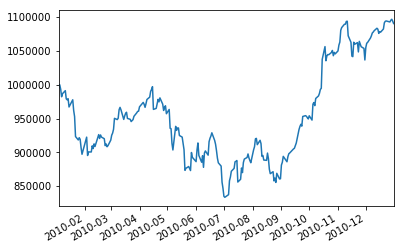

In [182]:
data = allocate_equities(allocs=[0.4,0.4,0.1,0.1])
data.plot()
plt.show()

In [183]:
sharpe_ratio(data,daily_rf=0.00037828653,portfolio=True)

0.0025074606866161506

In [184]:
risk(data,portfolio=True)

0.011184919199361128

In [185]:
def error_func(allocs):
    data = allocate_equities(allocs=allocs)
    #r = risk(data,portfolio=True) # 
    r= -sharpe_ratio(data,daily_rf=0.00037828653,portfolio=True)
    return r

In [199]:
guess = np.float32([0.25,0.25,0.25,0.25])
result = spo.minimize(error_func, guess, method='SLSQP', options={'disp':True},
         bounds=((0,1),(0,1),(0,1),(0,1)),
         constraints = ({ 'type': 'eq',
                         'fun': lambda inputs: 1 - np.sum(inputs) }))
print(result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.08968196003805502
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
[ 0.          0.          0.49185487  0.50814513]


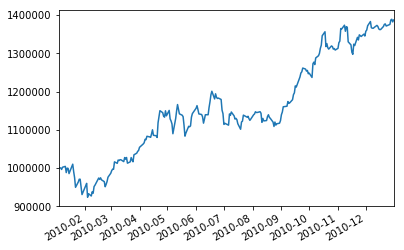

In [200]:
data = allocate_equities(allocs=[0,0,0.49185487,0.50814513])
data.plot()
plt.show()

In [201]:
sharpe_ratio(data,daily_rf=0.00037828653,portfolio=True)

0.0896819600384084